# Computer Vision End Semester Project

### This is a Working Example of generating Adversial Examples Using AlexNet and Pytorch.

#### Importing the required Libraries

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import cv2
from caffe_classes import class_names

#### Importing Pytorch

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam

#### Creating a class for loading AlexNet

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

#### Function to preprocess input for AlexNet

In [4]:
def preprocess(image):
    # For Imagenet
    ALEX_MEAN = [0.485, 0.456, 0.406]
    ALEX_STD=[0.229, 0.224, 0.225]
    
    # Other Preprocessing
    out = cv2.resize(image, (227, 227))
    out = out.astype(numpy.float32) / 256.
    image = numpy.clip(image, 0, 1)
    out = out[:, :, [2, 1, 0]]  # swap channel from BGR to RGB
    out[:, :, 0] = (out[:, :, 0] - ALEX_MEAN[0]) / ALEX_STD[0]
    out[:, :, 1] = (out[:, :, 1] - ALEX_MEAN[1]) / ALEX_STD[1]
    out[:, :, 2] = (out[:, :, 2] - ALEX_MEAN[2]) / ALEX_STD[2]
    out = numpy.transpose(out, (2, 0, 1))
    return out

#### Function to deprocess the output of AlexNet

In [5]:
def deprocess(tensor):
    ALEX_MEAN = [0.485, 0.456, 0.406]
    ALEX_STD=[0.229, 0.224, 0.225]
    
    out = tensor.data.cpu().numpy()
    out = numpy.reshape(out,[3, 227, 227])
    out = numpy.transpose(out, (1, 2, 0))
    # out = numpy.reshape(tensor,[227, 227, 3])
    
    out[:, :, 0] = (out[:, :, 0] * ALEX_STD[0]) + ALEX_MEAN[0]
    out[:, :, 1] = (out[:, :, 1] * ALEX_STD[1]) + ALEX_MEAN[1]
    out[:, :, 2] = (out[:, :, 2] * ALEX_STD[2]) + ALEX_MEAN[2]
    out = out[:, :, [2, 1, 0]]  # swap channel from RGB to BGR
    out = numpy.clip(out, 0, 1)
    out = out * 256
    
    out = out.astype(numpy.uint8)
    return out

#### Creating AlexNet and Loading its predefined Weights

In [6]:
pretrained = True
alexnet_path = 'models/alexnet-owt-4df8aa71.pth'

print("Creating Network")
model = AlexNet()
model.cuda()
model.requires_grad = False

# Loading Weights
print("Loading Network")
if pretrained == True:
    model.load_state_dict(torch.load(alexnet_path))
    print("Network Loaded Successfully")

Creating Network
Loading Network
Network Loaded Successfully


#### Loading the Specified Image

In [7]:
image_path = "cat.png"
image = cv2.imread(image_path)
original_image = numpy.copy(image)

#### Showing the Image

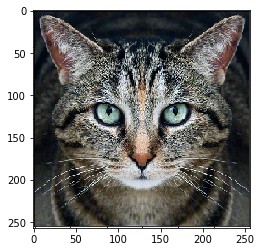

In [8]:
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

#### Predicting the class of Input Image

In [9]:
img = preprocess(image=original_image)
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.unsqueeze_(0)

In [10]:
img_variable = Variable(img_tensor.cuda(), requires_grad=True)
fc_out = model(img_variable)
fc_out = F.softmax(fc_out, dim=1)
class_name = class_names[fc_out.data.cpu().numpy().argmax()]

In [11]:
print("\nPredicted Class No.: {}". format(fc_out.data.cpu().numpy().argmax()))
print("Predicted Class Label: {}".format(class_name))


Predicted Class No.: 281
Predicted Class Label: tabby, tabby cat


#### Top 10 probabilities for input Image

Text(0.5,1,'Top 10 Probabilities of Input Image')

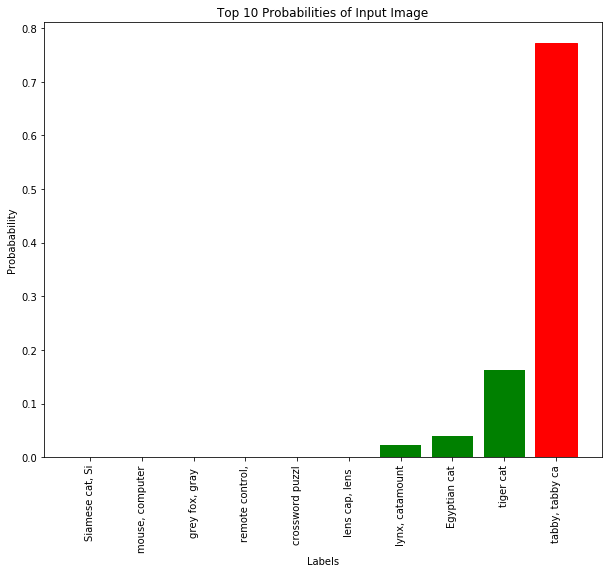

In [12]:
max_indices = numpy.argsort(numpy.reshape(fc_out.data.cpu().numpy(), [1000,]))[990:1000]
max_vals = numpy.reshape(fc_out.data.cpu().numpy(), [1000,])[max_indices]
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
rects = plt.bar(numpy.arange(10), max_vals, 0.8, color='g')
rects[9].set_color('r')
plt.xticks(range(10),
               [class_names[i][:15] for i in max_indices],
               rotation='vertical')
plt.tight_layout
plt.xlabel('Labels')
plt.ylabel('Probabability')
plt.title('Top 10 Probabilities of Input Image')

#### Setting Up the vector for target Class

In [13]:
target_class = 150

In [14]:
target_vector = numpy.array([target_class], dtype=numpy.int64)
target_tensor = torch.from_numpy(target_vector)
target_variable = Variable(target_tensor.cuda())
print("\nTarget Class No.: {}".format(target_class))
print("Target Class Name: {}".format(class_names[target_class]))


Target Class No.: 150
Target Class Name: sea lion


#### Creating Optimizer and Loss Function to update the Input Image

In [15]:
optimizer = Adam([img_variable], lr=0.001)
criteron = nn.CrossEntropyLoss()

#### Updating the input Image on basis of Cost function and optimizer

In [16]:
iterations = 501
print("\nStarting Optimization...")
for iteration in range(1,iterations):
    # img_variable = Variable(img_tensor, requires_grad=True)
    fc_out = model(img_variable)
    fc_out = F.softmax(fc_out, dim=1)

    optimizer.zero_grad()
    loss = criteron(fc_out, target_variable)
    
    loss.backward()
    optimizer.step()
    if iteration == 1 or iteration%10 == 0:
        print("Current Iteration: {}\tCurrent Cost: {}".format(iteration, numpy.round(loss.data[0], 6)))


Starting Optimization...
Current Iteration: 1	Current Cost: 6.909117
Current Iteration: 10	Current Cost: 6.909123
Current Iteration: 20	Current Cost: 6.909034
Current Iteration: 30	Current Cost: 6.908974
Current Iteration: 40	Current Cost: 6.909145
Current Iteration: 50	Current Cost: 6.90894
Current Iteration: 60	Current Cost: 6.90899
Current Iteration: 70	Current Cost: 6.908918
Current Iteration: 80	Current Cost: 6.909005
Current Iteration: 90	Current Cost: 6.90902
Current Iteration: 100	Current Cost: 6.908882
Current Iteration: 110	Current Cost: 6.908923
Current Iteration: 120	Current Cost: 6.908915
Current Iteration: 130	Current Cost: 6.908965
Current Iteration: 140	Current Cost: 6.9089
Current Iteration: 150	Current Cost: 6.908912
Current Iteration: 160	Current Cost: 6.908815
Current Iteration: 170	Current Cost: 6.908267
Current Iteration: 180	Current Cost: 6.908529
Current Iteration: 190	Current Cost: 6.908243
Current Iteration: 200	Current Cost: 6.760959
Current Iteration: 210	C

#### Obtaining the Final Output Image

In [17]:
final_image = deprocess(img_variable)
cv2.imwrite("output.jpg", final_image)

True

#### Showing the Final Output

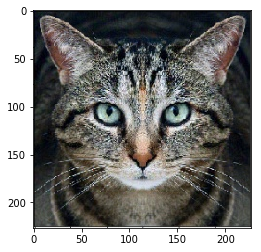

In [18]:
plt.imshow(cv2.cvtColor(cv2.imread("output.jpg"), cv2.COLOR_BGR2RGB))

#### Doing Prediction of Final Output Image

In [19]:
fc_out = model(img_variable)
fc_out = F.softmax(fc_out, dim=1)
class_name = class_names[fc_out.data.cpu().numpy().argmax()]
print("Predicted Class No.: {}". format(fc_out.data.cpu().numpy().argmax()))
print("Predicted Class: {}".format(class_name))

Predicted Class No.: 150
Predicted Class: sea lion


#### Getting the top 10 probabilities of output Image

Text(0.5,1,'Top 10 Probabilities of Output Image')

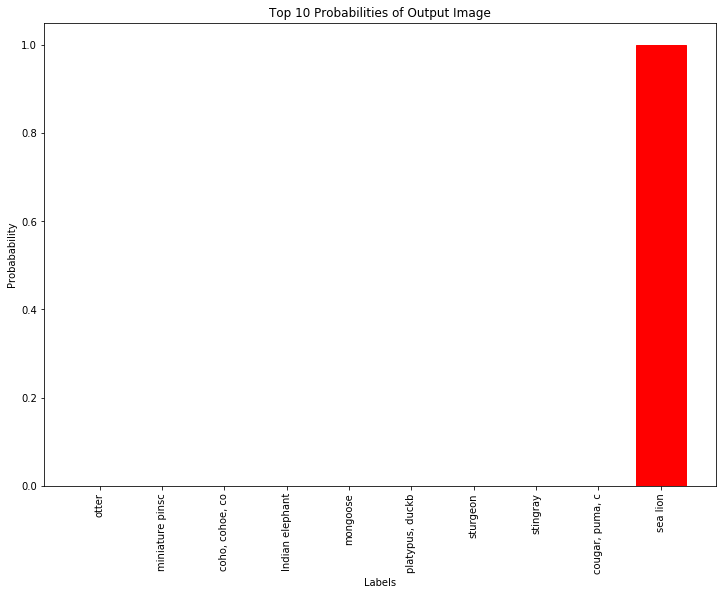

In [20]:
max_indices = numpy.argsort(fc_out.data.cpu().numpy().reshape([1000,]))[990:1000]
max_vals = numpy.reshape(fc_out.data.cpu().numpy(), [1000,])[max_indices]
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
rects = plt.bar(numpy.arange(10), max_vals, 0.8, color='g')
rects[9].set_color('r')
plt.xticks(range(10),
               [class_names[i][:15] for i in max_indices],
               rotation='vertical')
plt.tight_layout()
plt.xlabel('Labels')
plt.ylabel('Probabability')
plt.title('Top 10 Probabilities of Output Image')